# Inerpretation-Net Training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'data': {
        'd': 3, #degree
        'n': 5, #number of variables
        'monomial_vars': None, #int or None
        'laurent': False, #use Laurent polynomials (negative degree with up to -d)  
        'neg_d': 0,#int or None
        'neg_d_prob': 0,
        'sparsity': None,
        'sample_sparsity': 5,
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        'a_max': 1,
        'a_min': -1,
        'lambda_nets_total': 10000,
        'noise': 0,
        'noise_distrib': 'normal', #'normal', 'uniform', 'beta', 'Gamma', 'laplace'
        
        'function_generation_type': 'polynomial',# 'friedman', 'polynomial'
        
        'shift_polynomial': False,
        
        'border_min': 0.2, # defines an intervall. Value is randomly chosen and defines the minimum gap between x_min / x_max and the outermost stationary points => two values (left and right gap will be generated per variable)
        'border_max': 0.4,
        'lower_degree_prob': 0.5, # probability that the degree of the whole polynomial will be reduced
        'a_random_prob': 0.5, # probability that a random generated function is used without adjustement
                
        'global_stationary_prob': 1, # probability that all variables are used for adjustement (0 recommended for higher number of variables)
        'bulge_min': 1, # bulge_min and bulge_max define an intervall of how much the function is bulged
        'bulge_max': 4,
        'min_variables_used': 2, # defines an Intervall of how many variables are used to get stationary points and therefore adjust the function
        'max_variables_used': 6,
        'max_monomials': 7, # maximum number of monomials, before adjusting the function (monomial of degree 0 is always defined, but is included in this number)
        'max_monomials_random': 10, #maximum number of monomials for random generated functions
        
        'same_training_all_lambda_nets': False,

        'fixed_seed_lambda_training': True,
        'fixed_initialization_lambda_training': False,
        'number_different_lambda_trainings': 1,
    },
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True,  #if early stopping is used, multi_epoch_analysis is deactivated
        'early_stopping_min_delta_lambda': 1e-4,
        'batch_lambda': 64,
        'dropout': 0,
        'lambda_network_layers': [5*'sample_sparsity'],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'mae',
        'number_of_lambda_weights': None,
        'lambda_dataset_size': 5000,
    },
    'i_net': {
        'optimizer': 'adam',#adam
        'inet_loss': 'mae',
        'inet_metrics': ['r2'],
        'dropout': 0,
        'dropout_output': 0,
        'epochs': 2000, 
        'early_stopping': True,
        'batch_size': 256,
        'dense_layers': [4096, 2048, 1024, 512],
        'convolution_layers': None,
        'lstm_layers': None,
        'interpretation_dataset_size': 10000,
                
        'interpretation_net_output_monomials': 5, #(None, int) #CONSTANT IS NOT INCLUDED
        'interpretation_net_output_shape': None, #calculated automatically later
        'test_size': 50, #Float for fraction, Int for number 0
        
        'normalize_inet_data': False,
        'inet_training_without_noise': True, #dataset size without noise hardcoded to 50k in generate_paths
        'sparse_poly_representation_version': 1, #(1, 2); 1=old, 2=new
        'normalize_lambda_nets': False,

        'evaluate_with_real_function': False, #False
        'consider_labels_training': False, #False
                      
        'data_reshape_version': None, #default to 2 options:(None, 0,1 2)
        'nas': False,
        'nas_type': 'SEQUENTIAL', #options:(None, 'SEQUENTIAL', 'CNN', 'LSTM', 'CNN-LSTM', 'CNN-LSTM-parallel')      
        'nas_trials': 100,
    },
    'evaluation': {   
        'inet_holdout_seed_evaluation': False,
        
        #set if multi_epoch_analysis should be performed
        'multi_epoch_analysis': False,
        'each_epochs_save_lambda': 100,
        'epoch_start': 0, #use to skip first epochs in multi_epoch_analysis
        
        'max_optimization_minutes': 60,
        
        #set if samples analysis should be performed
        'samples_list': None,#[100, 500, 750, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 28125] 
       
        'random_evaluation_dataset_size': 500,
        'per_network_optimization_dataset_size': 5000,
        
        'adjusted_symbolic_metamodeling_code': False,
        'symbolic_metamodeling_evaluation': False,
        'symbolic_metamodeling_poly_evaluation': False,
        'symbolic_metamodeling_function_evaluation': False,
        'symbolic_metamodeling_poly_function_evaluation': False,
        
        'polynomial_regression_evaluation': True,
        'symbolic_regression_evaluation': True,
        'per_network_evaluation': False,
        
        'different_eval_data': True,
        
        'eval_data_description': {
            ######### data #########
            'eval_data_function_generation_type': 'polynomial',# 'friedman1', 'polynomial'
            'eval_data_lambda_dataset_size': 5000, #number of samples per function
            'eval_data_noise': 0, 
            'eval_data_noise_distrib': 'normal', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'     
            ######### lambda_net #########
            'eval_data_lambda_nets_total': 100,
            ######### i_net #########
            'eval_data_interpretation_dataset_size': 100,
            
        }        
        
    },
    'computation':{
        'train_model': True,
        'n_jobs': 20,
        'use_gpu': True,
        'gpu_numbers': '1',
        'RANDOM_SEED': 42,   
    }
}

## Imports

In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
#######################################################################################################################################
##################################################### IMPORT LIBRARIES ################################################################
#######################################################################################################################################
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
tf.get_logger().setLevel('WARNING')
tf.autograph.set_verbosity(2)

from itertools import product       
from tqdm import tqdm_notebook as tqdm
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import timeit
import psutil

from copy import deepcopy


from functools import reduce
from more_itertools import random_product 
from sklearn.preprocessing import Normalizer

import sys
import os
import shutil

from prettytable import PrettyTable
import colored
import math

import time
from datetime import datetime
from collections.abc import Iterable


from joblib import Parallel, delayed

from scipy.integrate import quad

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold, ParameterGrid, ParameterSampler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score

from similaritymeasures import frechet_dist, area_between_two_curves, dtw
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import tensorflow.keras.backend as K
from livelossplot import PlotLossesKerasTF
#from keras_tqdm import TQDMNotebookCallback

from matplotlib import pyplot as plt
import seaborn as sns

import random 

from IPython.display import Image
from IPython.display import display, Math, Latex, clear_output



In [4]:
tf.__version__

'2.6.0'

In [5]:
#######################################################################################################################################
################################################### VARIABLE ADJUSTMENTS ##############################################################
#######################################################################################################################################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

n_jobs = min((epochs_lambda//each_epochs_save_lambda+1, n_jobs)) if multi_epoch_analysis else min(len(samples_list), n_jobs) if samples_list!=None else 1

multi_epoch_analysis = False if early_stopping_lambda else multi_epoch_analysis #deactivate multi_epoch_analysis if early stopping is used

each_epochs_save_lambda = each_epochs_save_lambda if multi_epoch_analysis else epochs_lambda
epochs_save_range_lambda = range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda) if each_epochs_save_lambda == 1 else range(epoch_start//each_epochs_save_lambda, epochs_lambda//each_epochs_save_lambda+1) if multi_epoch_analysis else range(1,2)

data_reshape_version = 2 if data_reshape_version == None and (convolution_layers != None or lstm_layers != None or (nas and nas_type != 'SEQUENTIAL')) else data_reshape_version
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2, --tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")
#np.set_printoptions(suppress=True)

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

warnings.filterwarnings('ignore')

sys.path.append('..')

In [6]:
from utilities.utility_functions import flatten, rec_gen, gen_monomial_identifier_list

list_of_monomial_identifiers_extended = []

if laurent:
    variable_sets = [list(flatten([[_d for _d in range(d+1)], [-_d for _d in range(1, neg_d+1)]])) for _ in range(n)]
    list_of_monomial_identifiers_extended = rec_gen(variable_sets)    
        
    print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
    #print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
    #print('Sparsity:' + str(sparsity))
    if len(list_of_monomial_identifiers_extended) < 500:
        print(list_of_monomial_identifiers_extended)     
        
    list_of_monomial_identifiers = []
    for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
        if np.sum(monomial_identifier) <= d:
            if monomial_vars == None or len(list(filter(lambda x: x != 0, monomial_identifier))) <= monomial_vars:
                list_of_monomial_identifiers.append(monomial_identifier)        
else:
    variable_list = ['x'+ str(i) for i in range(n)]
    list_of_monomial_identifiers = gen_monomial_identifier_list(variable_list, d, n)
            
print('List length: ' + str(len(list_of_monomial_identifiers)))
#print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(sparsity))
#print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)


List length: 56
[[3, 0, 0, 0, 0], [2, 1, 0, 0, 0], [2, 0, 1, 0, 0], [2, 0, 0, 1, 0], [2, 0, 0, 0, 1], [2, 0, 0, 0, 0], [1, 2, 0, 0, 0], [1, 1, 1, 0, 0], [1, 1, 0, 1, 0], [1, 1, 0, 0, 1], [1, 1, 0, 0, 0], [1, 0, 2, 0, 0], [1, 0, 1, 1, 0], [1, 0, 1, 0, 1], [1, 0, 1, 0, 0], [1, 0, 0, 2, 0], [1, 0, 0, 1, 1], [1, 0, 0, 1, 0], [1, 0, 0, 0, 2], [1, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 3, 0, 0, 0], [0, 2, 1, 0, 0], [0, 2, 0, 1, 0], [0, 2, 0, 0, 1], [0, 2, 0, 0, 0], [0, 1, 2, 0, 0], [0, 1, 1, 1, 0], [0, 1, 1, 0, 1], [0, 1, 1, 0, 0], [0, 1, 0, 2, 0], [0, 1, 0, 1, 1], [0, 1, 0, 1, 0], [0, 1, 0, 0, 2], [0, 1, 0, 0, 1], [0, 1, 0, 0, 0], [0, 0, 3, 0, 0], [0, 0, 2, 1, 0], [0, 0, 2, 0, 1], [0, 0, 2, 0, 0], [0, 0, 1, 2, 0], [0, 0, 1, 1, 1], [0, 0, 1, 1, 0], [0, 0, 1, 0, 2], [0, 0, 1, 0, 1], [0, 0, 1, 0, 0], [0, 0, 0, 3, 0], [0, 0, 0, 2, 1], [0, 0, 0, 2, 0], [0, 0, 0, 1, 2], [0, 0, 0, 1, 1], [0, 0, 0, 1, 0], [0, 0, 0, 0, 3], [0, 0, 0, 0, 2], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0]]


In [7]:
from utilities.InterpretationNet import *
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################
config['evaluation']['multi_epoch_analysis'] = multi_epoch_analysis
config['evaluation']['each_epochs_save_lambda'] = each_epochs_save_lambda
config['i_net']['data_reshape_version'] = data_reshape_version

config['data']['sparsity'] = nCr(config['data']['n']+config['data']['d'], config['data']['d']) if not laurent else len(list_of_monomial_identifiers)
config['data']['sample_sparsity'] = config['data']['sparsity'] if config['data']['sample_sparsity'] == None else config['data']['sample_sparsity']

config['i_net']['interpretation_net_output_shape'] = config['data']['sparsity'] if config['i_net']['interpretation_net_output_monomials'] is None else config['data']['sparsity']*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials'] if config['i_net']['sparse_poly_representation_version'] == 1 else config['data']['n']*(config['data']['d']+1)*config['i_net']['interpretation_net_output_monomials']+config['i_net']['interpretation_net_output_monomials']  
print('Output Shape: ', config['i_net']['interpretation_net_output_shape'])

transformed_layers = []
for layer in config['lambda_net']['lambda_network_layers']:
    if type(layer) == str:
        transformed_layers.append(layer.count('sample_sparsity')*config['data']['sample_sparsity'])
    else:
        transformed_layers.append(layer)
config['lambda_net']['lambda_network_layers'] = transformed_layers

layers_with_input_output = list(flatten([[config['data']['n']], config['lambda_net']['lambda_network_layers'], [1]]))
number_of_lambda_weights = 0
for i in range(len(layers_with_input_output)-1):
    number_of_lambda_weights += (layers_with_input_output[i]+1)*layers_with_input_output[i+1]  
config['lambda_net']['number_of_lambda_weights'] = number_of_lambda_weights
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['i_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])



initialize_LambdaNet_config_from_curent_notebook(config)
initialize_metrics_config_from_curent_notebook(config)
initialize_utility_functions_config_from_curent_notebook(config)
initialize_InterpretationNet_config_from_curent_notebook(config)


#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(path_type='interpretation_net'))
create_folders_inet()

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

Output Shape:  285


In [8]:
print(path_identifier_interpretation_net_data)

print(path_identifier_lambda_net_data)


inet_dense4096-2048-1024-512-output_285_drop0e2000b256_adam/lnets_10000_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_5_d_3_negd_0_prob_0_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0_polynomial
lnets_10000_25-1000e_ES0.0001_64b_adam_mae_train_5000_diffX_1-FixSeed_42/var_5_d_3_negd_0_prob_0_spars_5_amin_-1_amax_1_xdist_uniform_noise_normal_0_polynomial


In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  1
Num XLA-GPUs Available:  1


## Load Data and Generate Datasets

In [10]:
def load_lambda_nets(config, index, no_noise=False):
        
    if psutil.virtual_memory().percent > 80:
        raise SystemExit("Out of RAM!")
                    
    path_identifier_lambda_net_data_loading = generate_paths(config, path_type='interpretation_net')['path_identifier_lambda_net_data']
        
    directory = './data/weights/' + 'weights_' + path_identifier_lambda_net_data_loading + '/'
    path_weights = directory + 'weights_epoch_' + str(index).zfill(3) + '.txt'
    path_X_data = directory + 'lambda_X_test_data.txt'
    path_y_data = directory + 'lambda_y_test_data.txt'        
    
    weight_data = pd.read_csv(path_weights, sep=",", header=None)
    weight_data = weight_data.sort_values(by=0).sample(n=config['i_net']['interpretation_dataset_size'], random_state=RANDOM_SEED)

    lambda_X_test_data = pd.read_csv(path_X_data, sep=",", header=None)
    lambda_X_test_data = lambda_X_test_data.sort_values(by=0).sample(n=config['i_net']['interpretation_dataset_size'], random_state=RANDOM_SEED)

    lambda_y_test_data = pd.read_csv(path_y_data, sep=",", header=None)
    lambda_y_test_data = lambda_y_test_data.sort_values(by=0).sample(n=config['i_net']['interpretation_dataset_size'], random_state=RANDOM_SEED)
    
    lambda_nets = [None] * weight_data.shape[0]
    for i, (row_weights, row_lambda_X_test_data, row_lambda_y_test_data) in enumerate(zip(weight_data.values, lambda_X_test_data.values, lambda_y_test_data.values)):        
        lambda_net = LambdaNet(row_weights, row_lambda_X_test_data, row_lambda_y_test_data)
        lambda_nets[i] = lambda_net
                
    lambda_net_dataset = LambdaNetDataset(lambda_nets)
        
    return lambda_net_dataset
    

In [11]:
#LOAD DATA
if different_eval_data:
    config_train = deepcopy(config)
    config_eval = deepcopy(config)
    
    config_eval['data']['function_generation_type'] = config['evaluation']['eval_data_description']['eval_data_function_generation_type']
    config_eval['data']['lambda_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_lambda_dataset_size']
    config_eval['data']['noise'] = config['evaluation']['eval_data_description']['eval_data_noise']
    config_eval['data']['noise_distrib'] = config['evaluation']['eval_data_description']['eval_data_noise_distrib'] 
    config_eval['data']['lambda_nets_total'] = config['evaluation']['eval_data_description']['eval_data_lambda_nets_total']   
    config_eval['i_net']['interpretation_dataset_size'] = config['evaluation']['eval_data_description']['eval_data_interpretation_dataset_size']   
    
    index = each_epochs_save_lambda

    lambda_net_dataset_train = load_lambda_nets(config_train, each_epochs_save_lambda)
    lambda_net_dataset_eval = load_lambda_nets(config_eval, each_epochs_save_lambda)

    lambda_net_dataset_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset_eval, test_split=test_size)    

    lambda_net_train_dataset_list = [lambda_net_dataset_train]
    lambda_net_valid_dataset_list = [lambda_net_dataset_valid]
    lambda_net_test_dataset_list = [lambda_net_dataset_test]
    
else:
    index = each_epochs_save_lambda
    
    lambda_net_dataset = load_lambda_nets(config, each_epochs_save_lambda)

    lambda_net_dataset_train_with_valid, lambda_net_dataset_test = split_LambdaNetDataset(lambda_net_dataset, test_split=test_size)
    lambda_net_dataset_train, lambda_net_dataset_valid = split_LambdaNetDataset(lambda_net_dataset_train_with_valid, test_split=0.1)    
    
    lambda_net_train_dataset_list = [lambda_net_dataset_train]
    lambda_net_valid_dataset_list = [lambda_net_dataset_valid]
    lambda_net_test_dataset_list = [lambda_net_dataset_test]
    

## Data Inspection

## Generate Datasets for Interpretation-Net training

In [12]:
lambda_net_train_dataset_list[-1].as_pandas().shape

(10000, 345)

In [13]:
lambda_net_valid_dataset_list[-1].as_pandas().shape

(50, 345)

In [14]:
lambda_net_test_dataset_list[-1].as_pandas().shape

(50, 345)

In [15]:
lambda_net_train_dataset_list[-1].as_pandas().head()

seed  30000-target  21000-target  20100-target  20010-target  \
6252  1373158606         0.000         0.000         0.000         0.000   
4684  1373158606         0.000         0.548         0.000         0.000   
1731  1373158606         0.000         0.000         0.000         0.000   
4742  1373158606        -0.098         0.000         0.857         0.000   
4521  1373158606         0.000         0.000         0.000         0.000   

      20001-target  20000-target  12000-target  11100-target  11010-target  \
6252         0.000         0.000         0.000         0.826         0.000   
4684         0.000         0.123         0.000         0.000         0.000   
1731         0.954         0.000         0.000         0.000         0.000   
4742         0.000         0.000         0.000         0.000         0.420   
4521         0.000         0.000         0.000         0.000         0.000   

      11001-target  11000-target  10200-target  10110-target  10101-target  \
6252         0.000        -0.175         0.000         0.000         0.000   
4684         0.000         0.000         0.000         0.000         0.000   
1731         0.000         0.000         0.000         0.000        -0.137   
4742         0.000         0.000         0.000        -0.118         0.000   
4521         0.000         0.000         0.144         0.000         0.000   

      10100-target  10020-target  10011-target  10010-target  10002-target  \
6252         0.000         0.000         0.000         0.000        -0.388   
4684         0.000         0.000         0.000         0.000         0.000   
1731         0.000         0.000         0.897         0.000         0.000   
4742         0.000         0.972         0.000         0.000         0.000   
4521         0.000         0.000        -0.915         0.000         0.000   

      10001-target  10000-target  03000-target  02100-target  02010-target  \
6252         0.000         0.000         0.000         0.000         0.000   
4684         0.000         0.000         0.000         0.000         0.000   
1731         0.000         0.000         0.000         0.000         0.000   
4742         0.000         0.000         0.000         0.000         0.000   
4521         0.000         0.000         0.000         0.000         0.000   

      02001-target  02000-target  01200-target  01110-target  01101-target  \
6252         0.000         0.000         0.000         0.000         0.000   
4684         0.000         0.313        -0.454         0.000         0.000   
1731         0.000         0.000         0.000         0.000         0.000   
4742         0.000         0.000         0.000         0.000         0.000   
4521         0.000         0.000        -0.311         0.000         0.000   

      01100-target  01020-target  01011-target  01010-target  01002-target  \
6252         0.000         0.000         0.000         0.182         0.000   
4684         0.000         0.000         0.000         0.000         0.000   
1731         0.000         0.000         0.000         0.000         0.000   
4742         0.000         0.000         0.000         0.000         0.000   
4521         0.000         0.000         0.486         0.033         0.000   

      01001-target  01000-target  00300-target  00210-target  00201-target  \
6252         0.000         0.000         0.000         0.000         0.000   
4684         0.000         0.000         0.000         0.000         0.000   
1731         0.762         0.000         0.000         0.000         0.000   
4742         0.000         0.000         0.000         0.000         0.000   
4521         0.000         0.000         0.000         0.000         0.000   

      00200-target  00120-target  00111-target  00110-target  00102-target  \
6252         0.000         0.000         0.000        -0.130         0.000   
4684         0.000         0.000         0.000         0.000         0.000   
1731         0.000         0.000      

In [16]:
lambda_net_valid_dataset_list[-1].as_pandas().head()

seed  30000-target  21000-target  20100-target  20010-target  \
69  1373158606         0.000         0.000         0.000         0.000   
45  1373158606         0.000         0.000         0.000         0.000   
77  1373158606         0.000         0.000         0.000         0.000   
35  1373158606         0.000         0.740         0.000         0.000   
10  1373158606         0.000         0.000         0.000         0.000   

    20001-target  20000-target  12000-target  11100-target  11010-target  \
69         0.000         0.000         0.000         0.052         0.000   
45         0.000         0.000         0.000         0.000         0.093   
77         0.000         0.000         0.000         0.000        -0.741   
35         0.000         0.000         0.000         0.208         0.000   
10         0.000         0.000         0.000         0.000         0.000   

    11001-target  11000-target  10200-target  10110-target  10101-target  \
69         0.000         0.000         0.000         0.000         0.000   
45        -0.312         0.000         0.000         0.000         0.000   
77         0.000        -0.694         0.000         0.000         0.000   
35         0.000        -0.896         0.000         0.000         0.000   
10        -0.990         0.000         0.000         0.661         0.000   

    10100-target  10020-target  10011-target  10010-target  10002-target  \
69         0.000         0.000         0.000         0.000         0.000   
45         0.000         0.000         0.000         0.000         0.000   
77         0.000         0.000         0.000         0.000         0.000   
35         0.000        -0.318         0.000         0.000         0.000   
10         0.000         0.000         0.000         0.000         0.000   

    10001-target  10000-target  03000-target  02100-target  02010-target  \
69         0.000         0.000         0.000         0.147         0.000   
45         0.000         0.000         0.000         0.000         0.000   
77         0.000         0.000         0.000         0.000         0.000   
35         0.000         0.000         0.000         0.000         0.000   
10         0.000         0.000         0.000         0.000         0.000   

    02001-target  02000-target  01200-target  01110-target  01101-target  \
69         0.000         0.000         0.514         0.000         0.000   
45         0.000         0.000         0.000         0.000         0.000   
77         0.000         0.000        -0.189         0.000         0.000   
35         0.000         0.000         0.000         0.000         0.000   
10         0.000         0.000         0.000         0.000         0.000   

    01100-target  01020-target  01011-target  01010-target  01002-target  \
69         0.000         0.000         0.000         0.000         0.000   
45         0.000         0.000        -0.816         0.000         0.000   
77         0.000         0.000         0.000         0.000         0.000   
35         0.000         0.000         0.000         0.000         0.000   
10         0.000         0.000         0.000         0.000         0.000   

    01001-target  01000-target  00300-target  00210-target  00201-target  \
69         0.000         0.000         0.000         0.000         0.000   
45        -0.219         0.000         0.000         0.000         0.000   
77        -0.447         0.000         0.000         0.000         0.872   
35         0.000         0.000         0.000         0.000         0.000   
10         0.000         0.000         0.000         0.000         0.000   

    00200-target  00120-target  00111-target  00110-target  00102-target  \
69         0.000         0.000         0.000         0.000         0.000   
45         0.000         0.000         0.000         0.000         0.000   
77         0.000         0.000         0.000         0.000         0.000   
35         0.000         0.154         0.000         0.000    

In [17]:
lambda_net_test_dataset_list[-1].as_pandas().head()

seed  30000-target  21000-target  20100-target  20010-target  \
29  1373158606         0.000         0.000         0.000         0.000   
38  1373158606         0.000         0.000         0.000         0.000   
79  1373158606         0.000         0.000         0.000         0.362   
19  1373158606         0.000         0.000         0.000         0.000   
27  1373158606         0.000         0.000         0.000         0.000   

    20001-target  20000-target  12000-target  11100-target  11010-target  \
29        -0.378         0.000         0.000         0.000         0.000   
38         0.000         0.000         0.000         0.000        -0.825   
79         0.000         0.000         0.000         0.000         0.000   
19         0.000         0.000         0.000         0.000         0.000   
27         0.000         0.000         0.000         0.000         0.000   

    11001-target  11000-target  10200-target  10110-target  10101-target  \
29         0.000         0.000         0.000         0.000         0.000   
38         0.000         0.000        -0.153         0.000         0.000   
79         0.000         0.000         0.000         0.000         0.000   
19         0.000         0.000         0.000         0.000         0.000   
27         0.000         0.000         0.000         0.000         0.000   

    10100-target  10020-target  10011-target  10010-target  10002-target  \
29         0.000         0.893         0.107         0.000         0.000   
38         0.000         0.000         0.000         0.000         0.000   
79         0.000         0.000         0.000        -0.775         0.000   
19         0.000         0.000         0.000         0.000         0.000   
27         0.000         0.000         0.000         0.000         0.349   

    10001-target  10000-target  03000-target  02100-target  02010-target  \
29         0.000         0.000         0.000         0.000         0.000   
38         0.000         0.000         0.000         0.000         0.000   
79         0.000         0.000         0.000         0.000         0.000   
19        -0.770        -0.546         0.000         0.000         0.000   
27         0.000        -0.357         0.000         0.000         0.000   

    02001-target  02000-target  01200-target  01110-target  01101-target  \
29         0.000         0.189         0.000        -0.146         0.000   
38         0.000         0.000         0.307         0.000        -0.988   
79         0.000         0.000         0.000         0.000         0.000   
19         0.000         0.690         0.000         0.927         0.000   
27         0.000         0.000         0.000         0.000        -0.824   

    01100-target  01020-target  01011-target  01010-target  01002-target  \
29         0.000         0.000         0.000         0.000         0.000   
38         0.000         0.000         0.000         0.000         0.000   
79         0.000         0.000         0.000         0.000         0.000   
19         0.000         0.000         0.000         0.000         0.000   
27         0.000         0.000         0.000         0.000         0.000   

    01001-target  01000-target  00300-target  00210-target  00201-target  \
29         0.000         0.000         0.000         0.000         0.000   
38         0.000         0.000         0.000         0.000         0.000   
79         0.000         0.000         0.000         0.000        -0.085   
19         0.000         0.069         0.000         0.000         0.000   
27         0.000         0.000         0.000         0.000         0.000   

    00200-target  00120-target  00111-target  00110-target  00102-target  \
29         0.000         0.000         0.000         0.000         0.000   
38         0.000         0.000         0.000         0.000        -0.225   
79         0.000         0.000         0.000        -0.717         0.000   
19         0.000         0.000         0.000         0.000    

## Interpretation Network Training

In [18]:
#%load_ext autoreload

In [19]:
lambda_net_train_dataset_list[0].weight_list[0].shape

(176,)

----------------------------------------------- TRAINING INTERPRETATION NET -----------------------------------------------
Epoch 1/2000
40/40 [==============================] - 34s 703ms/step - loss: 0.2866 - r2_inet_lambda_fv_loss: 2.2788 - val_loss: 0.1961 - val_r2_inet_lambda_fv_loss: 0.0990
Epoch 2/2000
40/40 [==============================] - 27s 685ms/step - loss: 0.2101 - r2_inet_lambda_fv_loss: 0.2155 - val_loss: 0.1828 - val_r2_inet_lambda_fv_loss: -0.0428
Epoch 3/2000
40/40 [==============================] - 27s 667ms/step - loss: 0.1936 - r2_inet_lambda_fv_loss: 0.0243 - val_loss: 0.1657 - val_r2_inet_lambda_fv_loss: -0.1987
Epoch 4/2000
40/40 [==============================] - 26s 657ms/step - loss: 0.1812 - r2_inet_lambda_fv_loss: -0.0601 - val_loss: 0.1663 - val_r2_inet_lambda_fv_loss: -0.1808
Epoch 5/2000
40/40 [==============================] - 27s 675ms/step - loss: 0.1833 - r2_inet_lambda_fv_loss: -0.0389 - val_loss: 0.1625 - val_r2_inet_lambda_fv_loss: -0.2426
Epoch

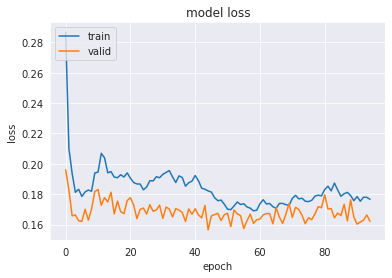

In [20]:
#%autoreload 2
((X_valid_list, y_valid_list), 
 (X_test_list, y_test_list),
 history_list, 

 #scores_valid_list,
 #scores_test_list, 

 #function_values_valid_list, 
 #function_values_test_list, 

 #polynomial_dict_valid_list,
 #polynomial_dict_test_list,

 #distrib_dict_valid_list,
 #distrib_dict_test_list,

 model_list) = interpretation_net_training(lambda_net_train_dataset_list, 
                                           lambda_net_valid_dataset_list, 
                                           lambda_net_test_dataset_list)



In [21]:
model_list[-1].summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 176)]        0                                            
__________________________________________________________________________________________________
hidden1_4096 (Dense)            (None, 4096)         724992      input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 4096)         0           hidden1_4096[0][0]               
__________________________________________________________________________________________________
hidden2_2048 (Dense)            (None, 2048)         8390656     activation1_relu[0][0]           
______________________________________________________________________________________________

In [22]:
#polynomial_dict_valid_list = []
polynomial_dict_test_list = []  
runtimes_list = []

for lambda_net_valid_dataset, lambda_net_test_dataset in zip(lambda_net_valid_dataset_list, lambda_net_test_dataset_list):

    #polynomial_dict_valid = {'lstsq_lambda_pred_polynomials': lambda_net_valid_dataset.lstsq_lambda_pred_polynomial_list,
    #                        'lstsq_target_polynomials': lambda_net_valid_dataset.lstsq_target_polynomial_list,
    #                        'target_polynomials': lambda_net_valid_dataset.target_polynomial_list}    

    polynomial_dict_test = {'lstsq_lambda_pred_polynomials': lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list,
                            'lstsq_target_polynomials': lambda_net_test_dataset.lstsq_target_polynomial_list,
                            'target_polynomials': lambda_net_test_dataset.target_polynomial_list}    

    #polynomial_dict_valid_list.append(polynomial_dict_valid)  
    polynomial_dict_test_list.append(polynomial_dict_test)
    runtimes_list.append({})
    



In [23]:
print('---------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------- PREDICT INET ------------------------------------------------------')

start = time.time() 

for i, (X_test, model) in enumerate(zip(X_test_list, model_list)):
    #y_test_pred = model.predict(X_test)    
    #print(model.summary())
    #print(X_test.shape)
    y_test_pred, inet_runtime = make_inet_prediction(model, X_test, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    #print(y_test_pred.shape)   
    polynomial_dict_test_list[i]['inet_polynomials'] = y_test_pred
    runtimes_list[i]['inet_runtime'] =  np.array([inet_runtime/len(lambda_net_test_dataset.target_polynomial_list) for _ in range(len(lambda_net_test_dataset.target_polynomial_list))])
    

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Predict Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

---------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------- PREDICT INET ------------------------------------------------------
Predict Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------


In [24]:
with tf.device('/CPU:0'):
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    if symbolic_metamodeling_poly_evaluation:
        print('-------------------------------------------------- CALCULATE METAMODEL POLY -----------------------------------------------')

        start = time.time() 

        for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
            metamodel_functions_test, metamodel_runtimes = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=True)
            polynomial_dict_test_list[i]['metamodel_poly'] = metamodel_functions_test     
            runtimes_list[i]['metamodel_poly_runtime'] = metamodel_runtimes

        end = time.time()     
        inet_train_time = (end - start) 
        minutes, seconds = divmod(int(inet_train_time), 60)
        hours, minutes = divmod(minutes, 60)        
        print('Metamodel Poly Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
        print('---------------------------------------------------------------------------------------------------------------------------') 


In [25]:
with tf.device('/CPU:0'):
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    if symbolic_metamodeling_evaluation:
        print('---------------------------------------------------- CALCULATE METAMODEL --------------------------------------------------')

        start = time.time() 

        for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
            metamodel_functions_test, metamodel_runtimes = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=False, force_polynomial=False)
            polynomial_dict_test_list[i]['metamodel_functions'] = metamodel_functions_test       
            runtimes_list[i]['metamodel_functions_runtime'] = metamodel_runtimes

        end = time.time()     
        inet_train_time = (end - start) 
        minutes, seconds = divmod(int(inet_train_time), 60)
        hours, minutes = divmod(minutes, 60)        
        print('Metamodel Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
        print('---------------------------------------------------------------------------------------------------------------------------') 


In [26]:
with tf.device('/CPU:0'):
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    if symbolic_metamodeling_function_evaluation:
        print('----------------------------------------------- CALCULATE METAMODEL FUNCTION ----------------------------------------------')

        start = time.time() 

        for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
            metamodel_functions_test, metamodel_runtimes = symbolic_metamodeling_function_generation(lambda_net_test_dataset, return_expression='approx', function_metamodeling=True)
            polynomial_dict_test_list[i]['metamodel_functions_no_GD'] = metamodel_functions_test   
            runtimes_list[i]['metamodel_functions_no_GD_runtime'] = metamodel_runtimes

        end = time.time()     
        inet_train_time = (end - start) 
        minutes, seconds = divmod(int(inet_train_time), 60)
        hours, minutes = divmod(minutes, 60)        
        print('Metamodel Function Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
        print('---------------------------------------------------------------------------------------------------------------------------') 


In [27]:
with tf.device('/CPU:0'):
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    if symbolic_regression_evaluation:
        print('----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------')

        start = time.time() 

        for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
            symbolic_regression_functions_test, symbolic_regression_runtimes = symbolic_regression_function_generation(lambda_net_test_dataset)
            polynomial_dict_test_list[i]['symbolic_regression_functions'] = symbolic_regression_functions_test    
            runtimes_list[i]['symbolic_regression_runtime'] = symbolic_regression_runtimes

        end = time.time()     
        inet_train_time = (end - start) 
        minutes, seconds = divmod(int(inet_train_time), 60)
        hours, minutes = divmod(minutes, 60)        
        print('Symbolic Regression Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
        print('---------------------------------------------------------------------------------------------------------------------------')    


----------------------------------------- CALCULATE SYMBOLIC REGRESSION FUNCTION ------------------------------------------


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
2021-11-16 10:47:55.388366: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-16 10:47:55.407975: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-16 10:47:55.414387: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-16 10:47:55.418665: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-16 10:47:55.421980: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-16 10:47:55.422059: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERR

Symbolic Regression Optimization Time: 0:06:03
---------------------------------------------------------------------------------------------------------------------------


[Parallel(n_jobs=20)]: Done  50 out of  50 | elapsed:  6.0min finished


In [28]:
%load_ext autoreload

In [29]:
%autoreload 2
with tf.device('/CPU:0'):
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    if polynomial_regression_evaluation:
        print('----------------------------------------- CALCULATE POLYNOMIAL REGRESSION FUNCTION ------------------------------------------')

        start = time.time() 

        for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
            polynomial_regression_functions_test, polynomial_regression_runtimes = polynomial_regression_function_generation(lambda_net_test_dataset)
            polynomial_dict_test_list[i]['polynomial_regression_functions'] = polynomial_regression_functions_test    
            runtimes_list[i]['polynomial_regression_runtime'] = polynomial_regression_runtimes

        end = time.time()     
        inet_train_time = (end - start) 
        minutes, seconds = divmod(int(inet_train_time), 60)
        hours, minutes = divmod(minutes, 60)        
        print('Polynomial Regression Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
        print('---------------------------------------------------------------------------------------------------------------------------')    
    #os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''


----------------------------------------- CALCULATE POLYNOMIAL REGRESSION FUNCTION ------------------------------------------


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done   3 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done   6 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done   7 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done  11 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done  16 out of  50 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=20)]: Done  21 out of  50 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=20)]: Done  26 out of  50 | elapsed:    0.6s remaining:    0.6

Polynomial Regression Optimization Time: 0:00:00
---------------------------------------------------------------------------------------------------------------------------


[Parallel(n_jobs=20)]: Done  41 out of  50 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=20)]: Done  46 out of  50 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  50 out of  50 | elapsed:    1.0s finished


In [30]:
#%autoreload 2
with tf.device('/CPU:0'):
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    if per_network_evaluation:
        print('------------------------------------------------ CALCULATE PER NETWORK POLY -----------------------------------------------')

        start = time.time() 

        for i, lambda_net_test_dataset in enumerate(lambda_net_test_dataset_list): 
            per_network_poly_test = per_network_poly_generation(lambda_net_test_dataset, optimization_type='scipy')
            polynomial_dict_test_list[i]['per_network_polynomials'] = per_network_poly_test       

        end = time.time()     
        inet_train_time = (end - start) 
        minutes, seconds = divmod(int(inet_train_time), 60)
        hours, minutes = divmod(minutes, 60)        
        print('Per Network Optimization Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
        print('---------------------------------------------------------------------------------------------------------------------------')


In [31]:
#%load_ext autoreload

In [32]:
print('------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------')                

start = time.time() 

function_values_test_list = []
for lambda_net_test_dataset, polynomial_dict_test in zip(lambda_net_test_dataset_list, polynomial_dict_test_list):
    function_values_test = calculate_all_function_values(lambda_net_test_dataset, polynomial_dict_test)
    function_values_test_list.append(function_values_test)

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('FV Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')

------------------------------------------------ CALCULATE FUNCTION VALUES ------------------------------------------------
True


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  35 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.


True
True
False


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=20)]: Using backend SequentialBackend with 1 concurrent workers.


metamodel_poly
Exit <class 'KeyError'>
metamodel_functions
Exit <class 'KeyError'>
metamodel_functions_no_GD
Exit <class 'KeyError'>
metamodel_functions_no_GD_poly
Exit <class 'KeyError'>
symbolic_regression_functions


[Parallel(n_jobs=20)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=20)]: Using backend SequentialBackend with 1 concurrent workers.


polynomial_regression_functions
per_network_polynomials
Exit <class 'KeyError'>
FV Calculation Time: 0:00:09
---------------------------------------------------------------------------------------------------------------------------


[Parallel(n_jobs=20)]: Done  50 out of  50 | elapsed:    1.4s finished


In [33]:
print('----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------')                

start = time.time() 

scores_test_list = []
distrib_dict_test_list = []
runtime_distrib_list = []
for function_values_test, polynomial_dict_test, runtimes_dict in zip(function_values_test_list, polynomial_dict_test_list, runtimes_list):
    scores_test, distrib_test = evaluate_all_predictions(function_values_test, polynomial_dict_test)
    scores_test_list.append(scores_test)
    distrib_dict_test_list.append(distrib_test)
    runtimes_list.append(pd.DataFrame(runtimes_dict))

end = time.time()     
inet_train_time = (end - start) 
minutes, seconds = divmod(int(inet_train_time), 60)
hours, minutes = divmod(minutes, 60)        
print('Score Calculation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')     
print('---------------------------------------------------------------------------------------------------------------------------')
print('---------------------------------------------------------------------------------------------------------------------------')         


----------------------------------------------------- CALCULATE SCORES ----------------------------------------------------
lambda_preds_VS_target_polynomials
lambda_preds_VS_lstsq_lambda_pred_polynomials
lambda_preds_VS_lstsq_target_polynomials
lambda_preds_VS_inet_polynomials
lambda_preds_VS_symbolic_regression_functions
lambda_preds_VS_polynomial_regression_functions
target_polynomials_VS_lstsq_lambda_pred_polynomials
target_polynomials_VS_lstsq_target_polynomials
target_polynomials_VS_inet_polynomials
target_polynomials_VS_symbolic_regression_functions
target_polynomials_VS_polynomial_regression_functions
lstsq_lambda_pred_polynomials_VS_lstsq_target_polynomials
lstsq_lambda_pred_polynomials_VS_inet_polynomials
lstsq_lambda_pred_polynomials_VS_symbolic_regression_functions
lstsq_lambda_pred_polynomials_VS_polynomial_regression_functions
lstsq_target_polynomials_VS_inet_polynomials
lstsq_target_polynomials_VS_symbolic_regression_functions
lstsq_target_polynomials_VS_polynomial_regre

In [34]:
identifier_type = 'epochs' if samples_list == None else 'samples'
save_results(scores_list=scores_test_list, by=identifier_type)

## Evaluate Interpretation Net

In [35]:
if nas:
    for trial in history_list[-1]: 
        print(trial.summary())

In [36]:
if len(model_list) >= 1:
    print(model_list[-1].summary())
    print(model_list[-1].get_config())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 176)]        0                                            
__________________________________________________________________________________________________
hidden1_4096 (Dense)            (None, 4096)         724992      input[0][0]                      
__________________________________________________________________________________________________
activation1_relu (Activation)   (None, 4096)         0           hidden1_4096[0][0]               
__________________________________________________________________________________________________
hidden2_2048 (Dense)            (None, 2048)         8390656     activation1_relu[0][0]           
______________________________________________________________________________________________

In [37]:
if evaluate_with_real_function:
    keys = ['inetPoly_VS_targetPoly_test', 'perNetworkPoly_VS_targetPoly_test', 'predLambda_VS_targetPoly_test', 'lstsqLambda_VS_targetPoly_test', 'lstsqTarget_VS_targetPoly_test']
else:
    keys = ['inetPoly_VS_predLambda_test', 'inetPoly_VS_lstsqLambda_test', 'perNetworkPoly_VS_predLambda_test', 'perNetworkPoly_VS_lstsqLambda_test', 'lstsqLambda_VS_predLambda_test', 'predLambda_VS_targetPoly_test']

In [38]:
#0.183	0.234	3.604	0.143	0.687	2.559	0.215

# TODO: INET NORMALIZATION TESTEN
# LARGER TRAINING DATA TESTEN
# FUNCTION SHIFTING TESTEN


In [39]:
scores_test_list[-1]

MAE  RMSE    MAPE  \
lambda_preds_VS_target_polynomials                   NaN   NaN     NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials        NaN   NaN     NaN   
lambda_preds_VS_lstsq_target_polynomials             NaN   NaN     NaN   
lambda_preds_VS_inet_polynomials                     NaN   NaN     NaN   
lambda_preds_VS_symbolic_regression_functions        NaN   NaN     NaN   
lambda_preds_VS_polynomial_regression_functions      NaN   NaN     NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.059 0.090   4.971   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000   0.000   
target_polynomials_VS_inet_polynomials             0.352 0.472  32.709   
target_polynomials_VS_symbolic_regression_funct...   NaN   NaN     NaN   
target_polynomials_VS_polynomial_regression_fun...   NaN   NaN     NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.059 0.090   1.819   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.356 0.472 101.868   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...   NaN   NaN     NaN   
lstsq_lambda_pred_polynomials_VS_polynomial_reg...   NaN   NaN     NaN   
lstsq_target_polynomials_VS_inet_polynomials       0.352 0.472  32.709   
lstsq_target_polynomials_VS_symbolic_regression...   NaN   NaN     NaN   
lstsq_target_polynomials_VS_polynomial_regressi...   NaN   NaN     NaN   
inet_polynomials_VS_symbolic_regression_functions    NaN   NaN     NaN   
inet_polynomials_VS_polynomial_regression_funct...   NaN   NaN     NaN   
symbolic_regression_functions_VS_polynomial_reg...   NaN   NaN     NaN   

                                                    Accuracy  \
lambda_preds_VS_target_polynomials                       NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials            NaN   
lambda_preds_VS_lstsq_target_polynomials                 NaN   
lambda_preds_VS_inet_polynomials                         NaN   
lambda_preds_VS_symbolic_regression_functions            NaN   
lambda_preds_VS_polynomial_regression_functions          NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...     0.606   
target_polynomials_VS_lstsq_target_polynomials         1.000   
target_polynomials_VS_inet_polynomials                 0.140   
target_polynomials_VS_symbolic_regression_funct...       NaN   
target_polynomials_VS_polynomial_regression_fun...       NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...     0.606   
lstsq_lambda_pred_polynomials_VS_inet_polynomials      0.148   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...       NaN   
lstsq_lambda_pred_polynomials_VS_polynomial_reg...       NaN   
lstsq_target_polynomials_VS_inet_polynomials           0.140   
lstsq_target_polynomials_VS_symbolic_regression...       NaN   
lstsq_target_polynomials_VS_polynomial_regressi...       NaN   
inet_polynomials_VS_symbolic_regression_functions        NaN   
inet_polynomials_VS_polynomial_regression_funct...       NaN   
symbolic_regression_functions_VS_polynomial_reg...       NaN   

                                                    Accuracy Multilabel  \
lambda_preds_VS_target_polynomials                                  NaN   
lambda_preds_VS_lstsq_lambda_pred_polynomials                       NaN   
lambda_preds_VS_lstsq_target_polynomials                            NaN   
lambda_preds_VS_inet_polynomials                                    NaN   
lambda_preds_VS_symbolic_regression_functions                       NaN   
lambda_preds_VS_polynomial_regression_functions                     NaN   
target_polynomials_VS_lstsq_lambda_pred_polynom...                0.000   
target_polynomials_VS_lstsq_target_polynomials                    1.000   
target_polynomials_VS_inet_polynomials                            0.000   
target_polynomials_VS_symbolic_regression_funct...                  NaN   
target_polynomials_VS_polynomial_regression_fun...                  NaN   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...                0.000   
lstsq_lambda_pred_polynomials_VS_inet_po

In [40]:
distrib_dict_test_list[-1]['MAE']

L-0   L-1   L-2   L-3  \
lambda_preds_VS_target_polynomials                 0.008 0.012 0.007 0.014   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.008 0.011 0.007 0.014   
lambda_preds_VS_lstsq_target_polynomials           0.008 0.012 0.007 0.014   
lambda_preds_VS_inet_polynomials                   0.083 0.125 0.094 0.304   
lambda_preds_VS_symbolic_regression_functions      0.060 0.044 0.041 0.114   
lambda_preds_VS_polynomial_regression_functions    0.063 0.068 0.047 0.064   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.006 0.009 0.004 0.009   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.082 0.127 0.094 0.306   
target_polynomials_VS_symbolic_regression_funct... 0.059 0.040 0.041 0.114   
target_polynomials_VS_polynomial_regression_fun... 0.062 0.070 0.048 0.064   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.006 0.009 0.004 0.009   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.082 0.124 0.094 0.305   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.061 0.042 0.041 0.113   
lstsq_lambda_pred_polynomials_VS_polynomial_reg... 0.062 0.066 0.047 0.063   
lstsq_target_polynomials_VS_inet_polynomials       0.082 0.127 0.094 0.306   
lstsq_target_polynomials_VS_symbolic_regression... 0.059 0.040 0.041 0.114   
lstsq_target_polynomials_VS_polynomial_regressi... 0.062 0.070 0.048 0.064   
inet_polynomials_VS_symbolic_regression_functions  0.052 0.144 0.125 0.306   
inet_polynomials_VS_polynomial_regression_funct... 0.042 0.097 0.107 0.263   
symbolic_regression_functions_VS_polynomial_reg... 0.058 0.090 0.054 0.096   

                                                     L-4   L-5   L-6   L-7  \
lambda_preds_VS_target_polynomials                 0.008 0.009 0.008 0.014   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.008 0.010 0.008 0.014   
lambda_preds_VS_lstsq_target_polynomials           0.008 0.009 0.008 0.014   
lambda_preds_VS_inet_polynomials                   0.141 0.142 0.179 0.131   
lambda_preds_VS_symbolic_regression_functions      0.038 0.083 0.034 0.101   
lambda_preds_VS_polynomial_regression_functions    0.062 0.059 0.047 0.077   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.005 0.006 0.003 0.010   
target_polynomials_VS_lstsq_target_polynomials     0.000 0.000 0.000 0.000   
target_polynomials_VS_inet_polynomials             0.141 0.142 0.178 0.132   
target_polynomials_VS_symbolic_regression_funct... 0.038 0.083 0.033 0.101   
target_polynomials_VS_polynomial_regression_fun... 0.063 0.059 0.047 0.077   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.005 0.006 0.003 0.010   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.140 0.140 0.179 0.130   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.036 0.083 0.033 0.098   
lstsq_lambda_pred_polynomials_VS_polynomial_reg... 0.061 0.059 0.046 0.074   
lstsq_target_polynomials_VS_inet_polynomials       0.141 0.142 0.178 0.132   
lstsq_target_polynomials_VS_symbolic_regression... 0.038 0.083 0.033 0.101   
lstsq_target_polynomials_VS_polynomial_regressi... 0.063 0.059 0.047 0.077   
inet_polynomials_VS_symbolic_regression_functions  0.144 0.142 0.183 0.083   
inet_polynomials_VS_polynomial_regression_funct... 0.140 0.156 0.168 0.091   
symbolic_regression_functions_VS_polynomial_reg... 0.057 0.075 0.041 0.057   

                                                     L-8   L-9  L-10  L-11  \
lambda_preds_VS_target_polynomials                 0.021 0.011 0.007 0.006   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.020 0.011 0.006 0.007   
lambda_preds_VS_lstsq_target_polynomials           0.021 0.011 0.007 0.006   
lambda_preds_VS_inet_polynomials                   0.167 0.079 0.358 0.281   
lambda_preds_VS_symbolic_regression_functions      0.115 0.049 0.066 0.099   
lambda_preds_VS_polynomial_regression_functions    0.068 0.058 0.043 0.050   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.011 0.006 0.004 0.00

In [41]:
distrib_dict_test_list[-1]['R2']

L-0    L-1   L-2    L-3  \
lambda_preds_VS_target_polynomials                 0.996  0.993 0.997  0.998   
lambda_preds_VS_lstsq_lambda_pred_polynomials      0.996  0.996 0.997  0.998   
lambda_preds_VS_lstsq_target_polynomials           0.996  0.993 0.997  0.998   
lambda_preds_VS_inet_polynomials                   0.580  0.424 0.485  0.246   
lambda_preds_VS_symbolic_regression_functions      0.771  0.922 0.896  0.888   
lambda_preds_VS_polynomial_regression_functions    0.754  0.807 0.893  0.962   
target_polynomials_VS_lstsq_lambda_pred_polynom... 0.998  0.997 0.999  0.999   
target_polynomials_VS_lstsq_target_polynomials     1.000  1.000 1.000  1.000   
target_polynomials_VS_inet_polynomials             0.580  0.411 0.490  0.242   
target_polynomials_VS_symbolic_regression_funct... 0.778  0.935 0.901  0.885   
target_polynomials_VS_polynomial_regression_fun... 0.753  0.794 0.888  0.961   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p... 0.998  0.997 0.999  0.999   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  0.577  0.422 0.486  0.247   
lstsq_lambda_pred_polynomials_VS_symbolic_regre... 0.766  0.925 0.899  0.890   
lstsq_lambda_pred_polynomials_VS_polynomial_reg... 0.754  0.811 0.896  0.963   
lstsq_target_polynomials_VS_inet_polynomials       0.580  0.411 0.490  0.242   
lstsq_target_polynomials_VS_symbolic_regression... 0.778  0.935 0.901  0.885   
lstsq_target_polynomials_VS_polynomial_regressi... 0.753  0.794 0.888  0.961   
inet_polynomials_VS_symbolic_regression_functions  0.562 -0.419 0.075 -1.664   
inet_polynomials_VS_polynomial_regression_funct... 0.751  0.414 0.414 -1.105   
symbolic_regression_functions_VS_polynomial_reg... 0.804  0.724 0.876  0.921   

                                                      L-4   L-5    L-6   L-7  \
lambda_preds_VS_target_polynomials                  0.996 0.997  0.999 0.990   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.997 0.998  0.999 0.992   
lambda_preds_VS_lstsq_target_polynomials            0.996 0.997  0.999 0.990   
lambda_preds_VS_inet_polynomials                   -0.018 0.483  0.317 0.260   
lambda_preds_VS_symbolic_regression_functions       0.923 0.763  0.980 0.476   
lambda_preds_VS_polynomial_regression_functions     0.801 0.910  0.958 0.716   
target_polynomials_VS_lstsq_lambda_pred_polynom...  0.999 0.999  1.000 0.995   
target_polynomials_VS_lstsq_target_polynomials      1.000 1.000  1.000 1.000   
target_polynomials_VS_inet_polynomials             -0.019 0.494  0.325 0.262   
target_polynomials_VS_symbolic_regression_funct...  0.920 0.753  0.980 0.462   
target_polynomials_VS_polynomial_regression_fun...  0.797 0.904  0.957 0.704   
lstsq_lambda_pred_polynomials_VS_lstsq_target_p...  0.999 0.999  1.000 0.995   
lstsq_lambda_pred_polynomials_VS_inet_polynomials  -0.020 0.498  0.324 0.254   
lstsq_lambda_pred_polynomials_VS_symbolic_regre...  0.926 0.765  0.980 0.477   
lstsq_lambda_pred_polynomials_VS_polynomial_reg...  0.803 0.909  0.959 0.722   
lstsq_target_polynomials_VS_inet_polynomials       -0.019 0.494  0.325 0.262   
lstsq_target_polynomials_VS_symbolic_regression...  0.920 0.753  0.980 0.462   
lstsq_target_polynomials_VS_polynomial_regressi...  0.797 0.904  0.957 0.704   
inet_polynomials_VS_symbolic_regression_functions  -0.337 0.631 -0.544 0.136   
inet_polynomials_VS_polynomial_regression_funct... -0.176 0.616 -0.252 0.061   
symbolic_regression_functions_VS_polynomial_reg...  0.836 0.804  0.971 0.462   

                                                      L-8   L-9          L-10  \
lambda_preds_VS_target_polynomials                  0.992 0.997         0.991   
lambda_preds_VS_lstsq_lambda_pred_polynomials       0.993 0.997         0.992   
lambda_preds_VS_lstsq_target_polynomials            0.992 0.997         0.991   
lambda_preds_VS_inet_polynomials                    0.487 0.826       -20.027   
lambda_preds_VS_symbolic_regression_functions       0.787 0.938        -0.079   
lambda_preds_VS_polynomial_regression_functio

In [42]:
runtimes_list[-1].values

array([[3.58737946e-03, 8.74832497e+01, 0.00000000e+00],
       [3.58737946e-03, 8.12843711e+01, 0.00000000e+00],
       [3.58737946e-03, 7.56309581e+01, 0.00000000e+00],
       [3.58737946e-03, 7.37120697e+01, 0.00000000e+00],
       [3.58737946e-03, 1.54545612e+02, 0.00000000e+00],
       [3.58737946e-03, 6.79018879e+01, 0.00000000e+00],
       [3.58737946e-03, 1.29800712e+02, 0.00000000e+00],
       [3.58737946e-03, 6.82087500e+01, 0.00000000e+00],
       [3.58737946e-03, 6.70555935e+01, 0.00000000e+00],
       [3.58737946e-03, 6.68777211e+01, 0.00000000e+00],
       [3.58737946e-03, 5.87233238e+01, 0.00000000e+00],
       [3.58737946e-03, 1.34763230e+02, 0.00000000e+00],
       [3.58737946e-03, 7.84367340e+01, 0.00000000e+00],
       [3.58737946e-03, 5.59087274e+01, 0.00000000e+00],
       [3.58737946e-03, 6.63457808e+01, 0.00000000e+00],
       [3.58737946e-03, 8.03490112e+01, 0.00000000e+00],
       [3.58737946e-03, 6.02073078e+01, 0.00000000e+00],
       [3.58737946e-03, 7.76043

In [44]:
if different_eval_data:
    config_save = config_eval
else:
    config_save = config

paths_dict = generate_paths(config, path_type = 'interpretation_net')

path_mae = './data/results/' + paths_dict['path_identifier_interpretation_net_data'] + '/mae_distrib_test_data_' + 'noise' + str(noise) + '_size' + str(interpretation_dataset_size) + '_' + str(function_generation_type) + '.csv'
path_r2 = './data/results/' + paths_dict['path_identifier_interpretation_net_data'] + '/r2_distrib_test_data_' + 'noise' + str(noise) + '_size' + str(interpretation_dataset_size) + '_' + str(function_generation_type) + '.csv'
path_runtimes = './data/results/' + paths_dict['path_identifier_interpretation_net_data'] + '/runtimes_' + 'noise' + str(noise) + '_size' + str(interpretation_dataset_size) + '_' + str(function_generation_type) + '.csv'
path_fv = './data/results/' + paths_dict['path_identifier_interpretation_net_data'] + '/fvs_' + 'noise' + str(noise) + '_size' + str(interpretation_dataset_size) + '_' + str(function_generation_type) + '.csv'
path_functions = './data/results/' + paths_dict['path_identifier_interpretation_net_data'] + '/functions_' + 'noise' + str(noise) + '_size' + str(interpretation_dataset_size) + '_' + str(function_generation_type) + '.csv'


distrib_dict_test_list[-1]['MAE'].to_csv(path_mae)
distrib_dict_test_list[-1]['R2'].to_csv(path_r2)
runtimes_list[-1].to_csv(path_runtimes)

with open(path_fv, 'wb') as f:
    pickle.dump(function_values_test_list[-1], f, protocol=2)

with open(path_functions, 'wb') as f:
    pickle.dump(polynomial_dict_test_list[-1], f, protocol=2)

    
    

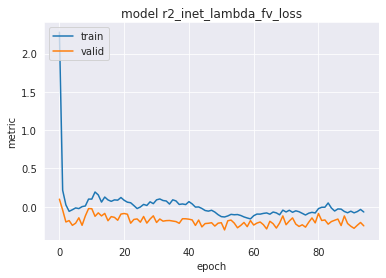

In [45]:
if not nas:
    history = history_list[-1]

    plt.plot(history[list(history.keys())[1]])
    try:
        plt.plot(history[list(history.keys())[len(history.keys())//2+1]]) 
    except:
        pass
    plt.title('model ' + list(history.keys())[1])
    plt.ylabel('metric')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/metric_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')


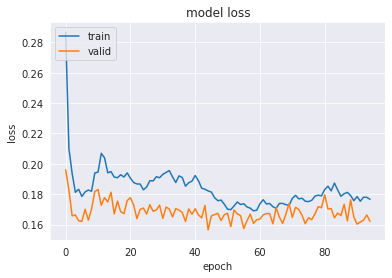

In [46]:
if not nas:
    history = history_list[-1]

    plt.plot(history['loss'])
    try:
        plt.plot(history['val_loss'])
    except:
        pass
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.savefig('./data/results/' + path_identifier_interpretation_net_data + '/loss_' + '_epoch_' + str(epochs_lambda).zfill(3) + '.png')    


### Multi Epoch/Sampes Analysis

### Generate Comparison Plots

In [47]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [48]:
if len(scores_test_list) > 1:
    plot_metric_list = ['MAE FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list)

In [49]:
if len(scores_test_list) > 1:
    plot_metric_list = ['R2 FV']

    generate_inet_comparison_plot(scores_test_list, plot_metric_list, ylim=(-5, 1))

#### Generate and Analyze Predictions for Random Function

In [50]:
index = 5

custom_representation_keys_fixed = ['target_polynomials']#['target_polynomials', 'lstsq_target_polynomials', 'lstsq_lambda_pred_polynomials']
custom_representation_keys_dynamic = ['inet_polynomials', 'per_network_polynomials']
sympy_representation_keys = ['metamodel_functions', 'symbolic_regression_functions', 'polynomial_regression_functions']


print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    if key in custom_representation_keys_fixed:
        print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
        print(key)        
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)
        print('MAE: ', distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_' + key][index])
        #print(polynomial_dict_test_list[-1][key][index])
    elif key in custom_representation_keys_dynamic:
        print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
        print(key)              
        print_polynomial_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)
        print('MAE: ', distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_' + key][index])
        #print(polynomial_dict_test_list[-1][key][index])
    elif key in sympy_representation_keys:
        print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
        print(key)              
        display(polynomial_dict_test_list[-1][key][index])
        print('MAE: ', distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_' + key][index])
    else:
        pass

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target_polynomials


0.0571*b**2*d - 0.6984*b**2*e - 0.7156*b*c**2 + 0.007*c**2*e - 0.5662*d

MAE:  0.009456367
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
inet_polynomials


-0.226500004529953*a**2*c - 1.07819998264313*b**2*c + 0.54229998588562*c**2*d - 0.572000026702881*c**2 - 0.673699975013733*d**3

MAE:  0.14156738
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
symbolic_regression_functions


-0.618*X1*X2 - 0.618*X3

MAE:  0.082683645
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
polynomial_regression_functions


-0.06568158789164207*x1**2 - 0.46722823661175017*x1*x2 - 0.29327124622839584*x1*x4 - 0.00861234462200299*x2**2 - 0.42345344810194346*x3 - 0.07447739295502676

MAE:  0.059332788
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [51]:
sym.expand(sympify('x1*x2*(x3+x4)'))

x1*x2*x3 + x1*x2*x4

In [52]:
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

for key in polynomial_dict_test_list[-1].keys():
    terms = []
    
    if key not in list(flatten([custom_representation_keys_fixed, custom_representation_keys_dynamic, sympy_representation_keys])):
        continue
    
    for index in range(5): #test_size
        if key in custom_representation_keys_fixed:
            string = str(round_expr(sym.expand(get_sympy_string_from_coefficients(polynomial_dict_test_list[-1][key][index], force_complete_poly_representation=True, round_digits=4)), 4))
        elif key in custom_representation_keys_dynamic:
            string = str(round_expr(sym.expand(get_sympy_string_from_coefficients(polynomial_dict_test_list[-1][key][index], round_digits=4)), 4))
        elif key in sympy_representation_keys:
            string = str(round_expr(sym.expand(polynomial_dict_test_list[-1][key][index]), 4))

        #print('string', string)
            
        try:
            str_split = string.split('-')

            str_split_2 = []
            for split in str_split:
                str_split_2.append(split.split('+'))

            str_split_2 = list(flatten(str_split_2))
            terms.append(len(str_split_2))
        except:
            pass        

    print(terms)
    terms_array = np.array(terms)
    print(key)          
    print('Complexity: ', np.mean(terms_array))
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')

    

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
[6, 6, 5, 6, 5]
target_polynomials
Complexity:  5.6
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
[5, 6, 6, 5, 6]
inet_polynomials
Complexity:  5.6
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
[2, 3, 3, 4, 6]
symbolic_regre

In [53]:
print('Target Poly: ', str(get_sympy_string_from_coefficients(polynomial_dict_test_list[-1]['target_polynomials'][index], force_complete_poly_representation=True, round_digits=4)))
print('Inet Poly: ', str(round_expr(get_sympy_string_from_coefficients(polynomial_dict_test_list[-1]['inet_polynomials'][index], round_digits=4), 4)))

try:
    print('SR Function: ', str(round_expr(polynomial_dict_test_list[-1]['symbolic_regression_functions'][index], 4)))
except:
    pass
    
try:
    print('PR Poly: ', str(round_expr(polynomial_dict_test_list[-1]['polynomial_regression_functions'][index], 4)))
except:
    pass
    
try:
    print('SM Poly: ', str(round_expr(polynomial_dict_test_list[-1]['metamodel_poly'][index], 10)))
except:
    pass

try:
    print('SM Function: ', str(round_expr(polynomial_dict_test_list[-1]['metamodel_functions'][index], 10)))
except:
    pass


Target Poly:  0.349*a*e**2 - 0.3567*a - 0.8236*b*c*e + 0.0116*d*e - 0.4363*e**3
Inet Poly:  -0.5502*a**2*c - 0.4771*b**2*c + 0.2982*c**2*d - 0.1356*c**2 - 0.1659*d
SR Function:  -0.294*X0 - X4*(X1 + X4)*(0.294*X2 + 0.1488)
PR Poly:  -0.1171*x0 - 0.0891*x1*x2 - 0.1523*x1*x4 - 0.1476*x2*x4 - 0.0791*x4**3 - 0.0974*x4**2 - 0.1226


In [54]:
lambda_net_test_dataset_list[-1].weight_list[index]

array([-0.07273543, -0.0729558 ,  0.23656368,  0.12193012,  0.16828744,
        0.12039838,  0.17815214, -0.16286384,  0.22265686,  0.14563195,
        0.34373236, -0.11876404, -0.03434271,  0.3751153 ,  0.11358184,
        0.434611  ,  0.0561237 ,  0.21049055,  0.28127298,  0.09943134,
       -0.09277485,  0.21629155,  0.03723716,  0.03960934, -0.42350462,
       -0.14527103,  0.13650125, -0.04372644, -0.21196333, -0.23366657,
        0.28054595,  0.4216999 ,  0.06996457,  0.30616722, -0.21243815,
       -0.5126824 , -0.51574445,  0.08911782, -0.06706607, -0.21925405,
        0.08636102,  0.27439964,  0.40706226, -0.27695143,  0.4425448 ,
        0.02724609,  0.14294341,  0.28726324,  0.32295093, -0.32792276,
       -0.09917568,  0.10482644, -0.39780593, -0.2982397 , -0.36753765,
        0.385481  ,  0.42797494,  0.0420745 ,  0.05376484, -0.28423494,
       -0.05240509,  0.31824887,  0.31363705,  0.23927234,  0.25019145,
        0.0498595 , -0.34079662,  0.3394713 ,  0.02517774, -0.41

In [55]:
if n==1:
    from IPython.display import clear_output

    for i in tqdm(range(test_size)):
        clear_output(wait=True)
        plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                              function_values_test_list, 
                                                              polynomial_dict_test_list,
                                                              rand_index=i, 
                                                              plot_type=1)

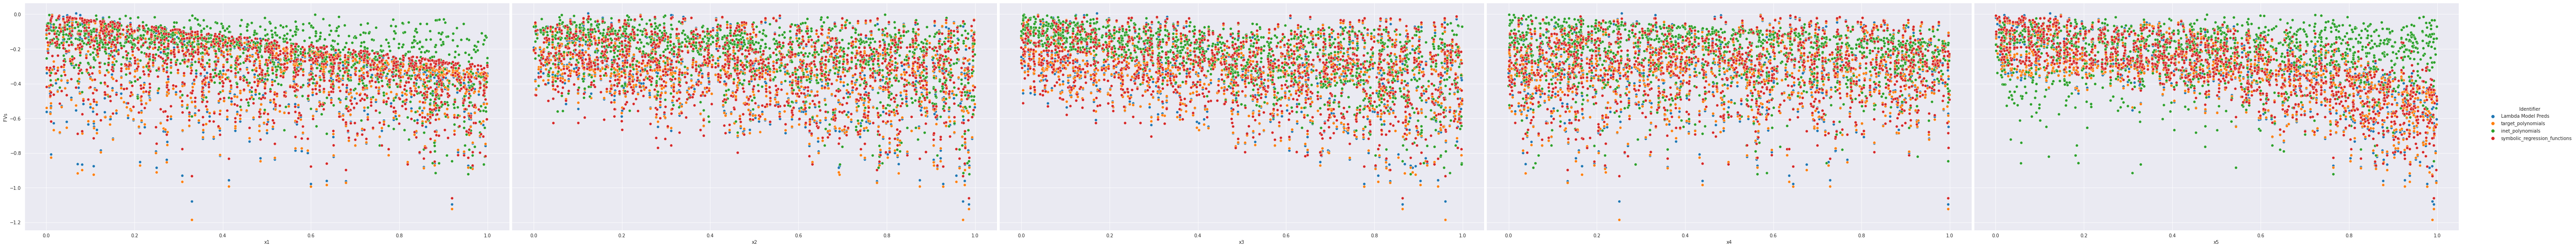

In [56]:
try:
    plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                          function_values_test_list, 
                                                          polynomial_dict_test_list,
                                                          rand_index=index, 
                                                          plot_type=1)
except:
    pass

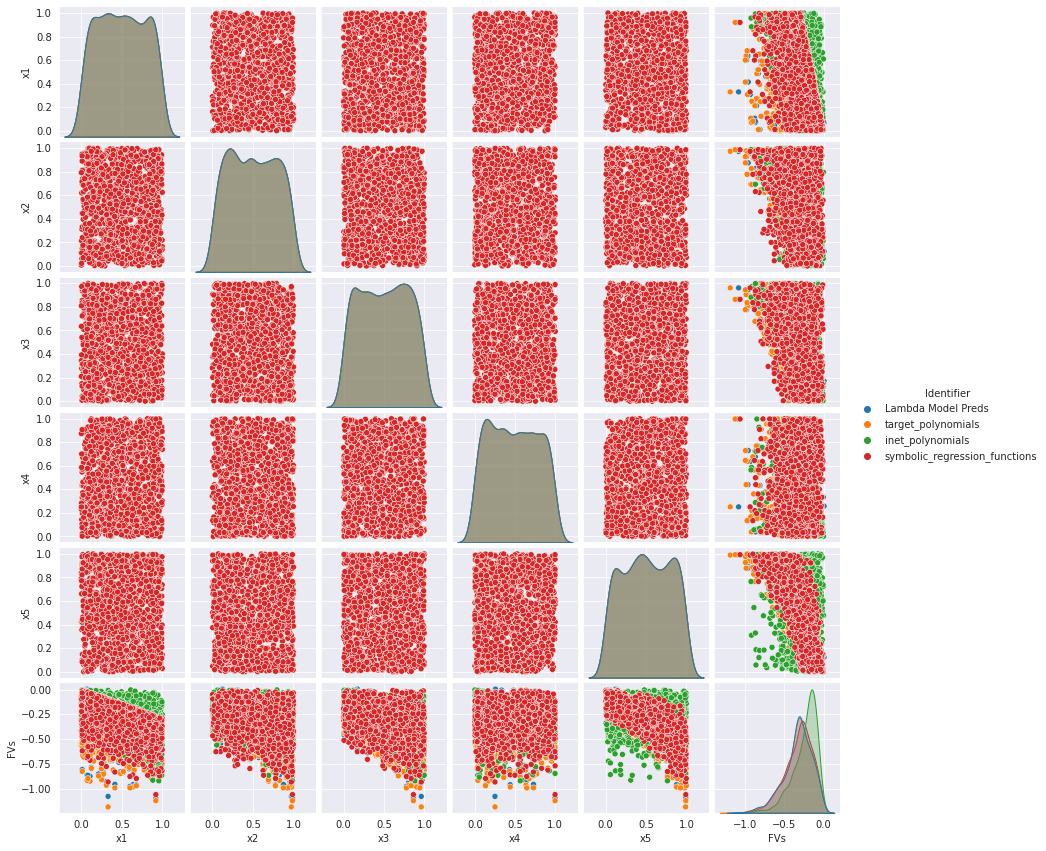

In [57]:
try:
    plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                          function_values_test_list, 
                                                          polynomial_dict_test_list,
                                                          rand_index=index, 
                                                          plot_type=2)
except:
    pass

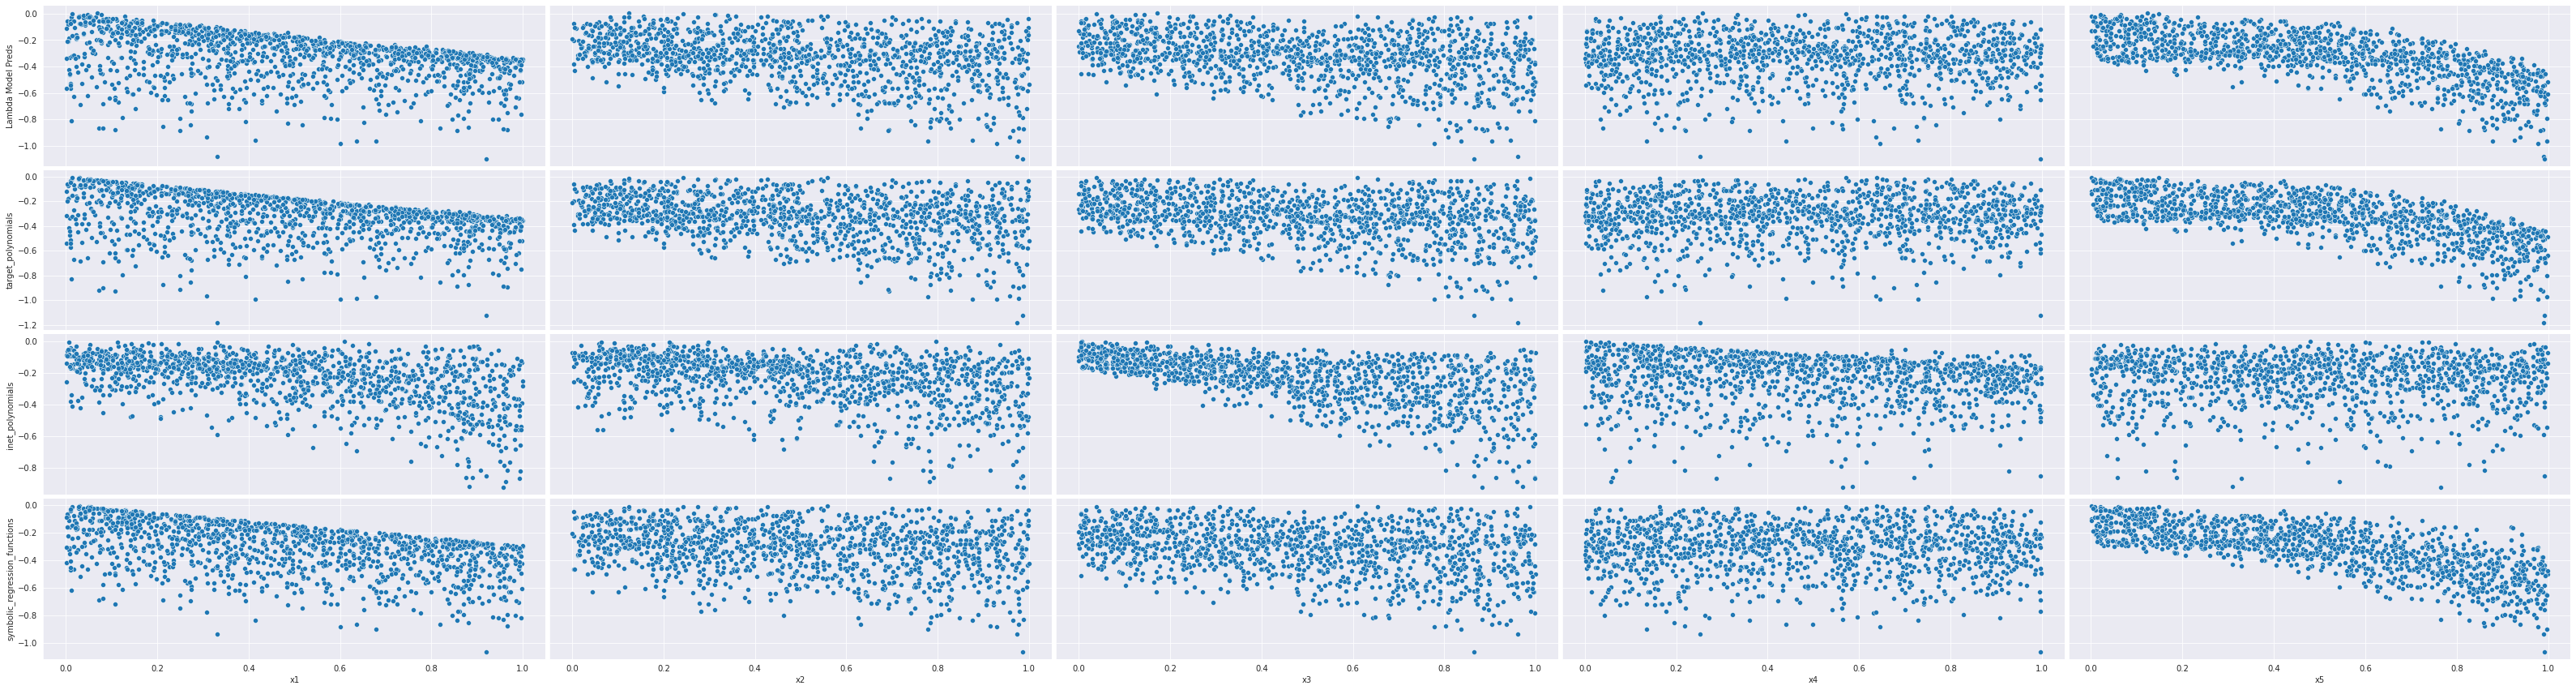

In [58]:
try:
    plot_and_save_single_polynomial_prediction_evaluation(lambda_net_test_dataset_list, 
                                                          function_values_test_list, 
                                                          polynomial_dict_test_list,
                                                          rand_index=index, 
                                                          plot_type=3)
except:
    pass

In [59]:
runtimes_list[-1].values

array([[3.58737946e-03, 8.74832497e+01, 0.00000000e+00],
       [3.58737946e-03, 8.12843711e+01, 0.00000000e+00],
       [3.58737946e-03, 7.56309581e+01, 0.00000000e+00],
       [3.58737946e-03, 7.37120697e+01, 0.00000000e+00],
       [3.58737946e-03, 1.54545612e+02, 0.00000000e+00],
       [3.58737946e-03, 6.79018879e+01, 0.00000000e+00],
       [3.58737946e-03, 1.29800712e+02, 0.00000000e+00],
       [3.58737946e-03, 6.82087500e+01, 0.00000000e+00],
       [3.58737946e-03, 6.70555935e+01, 0.00000000e+00],
       [3.58737946e-03, 6.68777211e+01, 0.00000000e+00],
       [3.58737946e-03, 5.87233238e+01, 0.00000000e+00],
       [3.58737946e-03, 1.34763230e+02, 0.00000000e+00],
       [3.58737946e-03, 7.84367340e+01, 0.00000000e+00],
       [3.58737946e-03, 5.59087274e+01, 0.00000000e+00],
       [3.58737946e-03, 6.63457808e+01, 0.00000000e+00],
       [3.58737946e-03, 8.03490112e+01, 0.00000000e+00],
       [3.58737946e-03, 6.02073078e+01, 0.00000000e+00],
       [3.58737946e-03, 7.76043

In [60]:
try:
    distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_inet_polynomials'].values
except:
    pass

In [61]:
try:
    distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_symbolic_regression_functions'].values
except:
    pass

In [62]:
try:
    distrib_dict_test_list[-1]['MAE'].loc['lambda_preds_VS_metamodel_functions'].values
except:
    pass

In [63]:
try:
    distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_inet_polynomials'].values
except:
    pass

In [64]:
try:
    distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_symbolic_regression_functions'].values
except:
    pass

In [65]:
try:
    distrib_dict_test_list[-1]['R2'].loc['lambda_preds_VS_metamodel_functions'].values
except:
    pass

In [66]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()

In [67]:
STOP

NameError: name 'STOP' is not defined

# BENCHMARK (RANDOM GUESS) EVALUATION

In [ ]:
list_of_random_polynomials = np.random.uniform(low=-10, high=10, size=(len(lambda_net_test_dataset_list[-1]), sparsity))

In [ ]:
true_fv_test = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)
random_fv_test = parallel_fv_calculation_from_polynomial(list_of_random_polynomials, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

In [ ]:
print('Random Guess Error Coefficients: ' + str(np.round(mean_absolute_error(lambda_net_test_dataset_list[-1].target_polynomial_list, list_of_random_polynomials), 4)))

In [ ]:
print('Random Guess Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, random_fv_test), 4)))

# BENCHMARK (EDUCATED GUESS/MEAN PREDICTION) EVALUATION

In [ ]:
true_fv_train = parallel_fv_calculation_from_polynomial(lambda_net_test_dataset_list[-1].target_polynomial_list, lambda_net_test_dataset_list[-1].X_test_data_list, force_complete_poly_representation=True)

mean_fv = np.mean(true_fv_train)
mean_fv_pred_test = [mean_fv for _ in range(true_fv_test.shape[0])]

In [ ]:
print('Educated Guess/Mean Prediction Error FVs: ' + str(np.round(mean_absolute_error_function_values(true_fv_test, mean_fv_pred_test), 4)))

In [ ]:
%%script false --no-raise-error

base_model = generate_base_model()
random_evaluation_dataset = np.random.uniform(low=x_min, high=x_max, size=(random_evaluation_dataset_size, n))
#random_evaluation_dataset = lambda_train_input_train_split[0]#lambda_train_input[0] #JUST [0] HERE BECAUSE EVALUATION ALWAYS ON THE SAME DATASET FOR ALL!!
list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)


loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

#X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))


seed_in_inet_training = False

loss_function = mean_absolute_error_tf_fv_lambda_extended_wrapper(random_evaluation_dataset, list_of_monomial_identifiers_numbers, base_model)      

X_train = X_train_list[-1].values[:,1:]
y_train = y_train_list[-1].values[:,2:]

X_train = X_train[:,1:]
y_train_model = np.hstack((y_train, X_train))

print('seed_in_inet_training = ' + str(seed_in_inet_training), loss_function(y_train_model, y_train))

seed_in_inet_training = True



In [ ]:
lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
current_jobs = 1

lr=0.5
max_steps = 100
early_stopping=10
restarts=2
per_network_dataset_size = 500

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

if n_jobs != -1:
    n_jobs_per_network = min(n_jobs, os.cpu_count() // current_jobs)
else: 
    n_jobs_per_network = os.cpu_count() // current_jobs - 1

printing = True if n_jobs_per_network == 1 else False


lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
if evaluate_with_real_function: #target polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.target_polynomial_list)
else: #lstsq lambda pred polynomial as inet target
    poly_representation_list = np.array(lambda_net_test_dataset.lstsq_lambda_pred_polynomial_list)


config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }


lambda_network_weights = lambda_network_weights_list[0]
poly_representation = poly_representation_list[0]



per_network_poly_optimization_tf(per_network_dataset_size, 
                                lambda_network_weights, 
                                  list_of_monomial_identifiers_numbers, 
                                  config, 
                                  lr=lr, 
                                  max_steps = max_steps, 
                                  early_stopping=early_stopping, 
                                  restarts=restarts, 
                                  printing=True)


# Evaluate Real Dataset


##  Auto MPG-Dataset

In [ ]:
interpretation_possible_autoMPG = False
print_head_autoMPG = None

url_autoMPG = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names_autoMPG = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset_autoMPG = pd.read_csv(url_autoMPG, names=column_names_autoMPG,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset_autoMPG = raw_dataset_autoMPG.dropna()

dataset_autoMPG['Origin'] = dataset_autoMPG['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset_autoMPG = pd.get_dummies(dataset_autoMPG, columns=['Origin'], prefix='', prefix_sep='')


features_autoMPG = dataset_autoMPG.copy()

labels_autoMPG = features_autoMPG.pop('MPG')

features_autoMPG_normalized = (features_autoMPG-features_autoMPG.min())/(features_autoMPG.max()-features_autoMPG.min())

#labels_autoMPG = (labels_autoMPG-labels_autoMPG.min())/(labels_autoMPG.max()-labels_autoMPG.min())


if features_autoMPG_normalized.shape[1] >= n:
    if n == 1:
        features_autoMPG_model = features_autoMPG_normalized[['Horsepower']]
    elif n == features_autoMPG_normalized.shape[1]:
        features_autoMPG_model = features_autoMPG_normalized
    else:
        features_autoMPG_model = features_autoMPG_normalized.sample(n=n, axis='columns')
        
    print_head_autoMPG = features_autoMPG_model.head()
    interpretation_possible_autoMPG = True

print_head_autoMPG

In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    ((lambda_index_autoMPG, 
     current_seed_autoMPG, 
     polynomial_autoMPG, 
     polynomial_lstsq_pred_list_autoMPG, 
     polynomial_lstsq_true_list_autoMPG), 
    scores_list_autoMPG, 
    pred_list_autoMPG, 
    history_autoMPG, 
    model_autoMPG) = train_nn(lambda_index=0, 
                              X_data_lambda=features_autoMPG_model.values, 
                              y_data_real_lambda=labels_autoMPG.values, 
                              polynomial=None, 
                              seed_list=[RANDOM_SEED], 
                              callbacks=[PlotLossesKerasTF()], 
                              return_history=True, 
                              each_epochs_save=None, 
                              printing=False, 
                              return_model=True)
    
    polynomial_lstsq_pred_autoMPG = polynomial_lstsq_pred_list_autoMPG[-1]

In [ ]:
if interpretation_possible_autoMPG and n==1:
    x = tf.linspace(0.0, 250, 251)
    y = model_autoMPG.predict(x)

    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
config = {
        'n': n,
        'd': d,
        'inet_loss': inet_loss,
        'sparsity': sparsity,
        'lambda_network_layers': lambda_network_layers,
        'interpretation_net_output_shape': interpretation_net_output_shape,
        'RANDOM_SEED': RANDOM_SEED,
        'nas': nas,
        'number_of_lambda_weights': number_of_lambda_weights,
        'interpretation_net_output_monomials': interpretation_net_output_monomials,
        'fixed_initialization_lambda_training': fixed_initialization_lambda_training,
        'dropout': dropout,
        'lambda_network_layers': lambda_network_layers,
        'optimizer_lambda': optimizer_lambda,
        'loss_lambda': loss_lambda,        
         #'list_of_monomial_identifiers': list_of_monomial_identifiers,
         'x_min': x_min,
         'x_max': x_max,
         }

weights_autoMPG = model_autoMPG.get_weights()

weights_flat_autoMPG = []
for layer_weights, biases in pairwise(weights_autoMPG):    #clf.get_weights()
    for neuron in layer_weights:
        for weight in neuron:
            weights_flat_autoMPG.append(weight)
    for bias in biases:
        weights_flat_autoMPG.append(bias)
        
weights_flat_autoMPG = np.array(weights_flat_autoMPG)


x = pred_list_autoMPG['X_test_lambda']
y = pred_list_autoMPG['y_test_real_lambda']

y_model_autoMPG = model_autoMPG.predict(x)




In [ ]:
if interpretation_possible_autoMPG:
    y_polynomial_lstsq_pred_autoMPG = calculate_function_values_from_polynomial(polynomial_lstsq_pred_autoMPG, x, force_complete_poly_representation=True)

    mae_model_polynomial_lstsq_pred_autoMPGy = mean_absolute_error(y_model_autoMPG, y_polynomial_lstsq_pred_autoMPG)
    mae_data_polynomial_lstsq_pred_autoMPG = mean_absolute_error(y, y_polynomial_lstsq_pred_autoMPG)

    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQt Poly:')
    print_polynomial_from_coefficients(y_polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('MAE Model: ', mae_model_polynomial_lstsq_pred_autoMPGy)
    print('MAE Data: ', mae_data_polynomial_lstsq_pred_autoMPG)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    interpretation_net = model_list[-1]
    
    start = time.time() 
    
    #interpretation_net_poly = interpretation_net.predict(np.array([weights_flat_autoMPG]))[0]
    interpretation_net_poly = make_inet_prediction(interpretation_net, weights_flat_autoMPG, network_data=None, lambda_trained_normalized=False, inet_training_normalized=normalize_inet_data, normalization_parameter_dict=None)
    
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_interpretation_net_poly = calculate_function_values_from_polynomial(interpretation_net_poly, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_interpretation_net_poly)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_interpretation_net_poly)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)    
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:

    start = time.time() 
    
    if False:
        per_network_hyperparams = {
            'optimizer':  'Powell',
            'jac': 'fprime',
            'max_steps': 5000,#100,
            'restarts': 3,
            'per_network_dataset_size': 500,
        }      
        
        per_network_function =  per_network_poly_optimization_scipy(per_network_dataset_size, 
                                                                  weights_flat_autoMPG, 
                                                                  list_of_monomial_identifiers_numbers, 
                                                                  config, 
                                                                  optimizer = per_network_hyperparams['optimizer'],
                                                                  jac = per_network_hyperparams['jac'],
                                                                  max_steps = per_network_hyperparams['max_steps'], 
                                                                  restarts=per_network_hyperparams['restarts'], 
                                                                  printing=True,
                                                                  return_error=False)
    else:
        per_network_hyperparams = {
            'optimizer': tf.keras.optimizers.RMSprop,
            'lr': 0.02,
            'max_steps': 500,
            'early_stopping': 10,
            'restarts': 3,
            'per_network_dataset_size': 5000,
        }   
        
        per_network_function =  per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                              weights_flat_autoMPG, 
                                                              list_of_monomial_identifiers_numbers, 
                                                              config, 
                                                              optimizer = per_network_hyperparams['optimizer'],
                                                              lr=per_network_hyperparams['lr'], 
                                                              max_steps = per_network_hyperparams['max_steps'], 
                                                              early_stopping=per_network_hyperparams['early_stopping'], 
                                                              restarts=per_network_hyperparams['restarts'], 
                                                              printing=True,
                                                              return_error=False)
            
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)  
    
    y_per_network_function = calculate_function_values_from_polynomial(per_network_function, x, force_complete_poly_representation=False)
    
    mae_model_interpretation_net_poly = mean_absolute_error(y_model_autoMPG, y_per_network_function)
    mae_data_interpretation_net_poly = mean_absolute_error(y, y_per_network_function)    
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function)
    print('MAE Model: ', mae_model_interpretation_net_poly)
    print('MAE Data: ', mae_data_interpretation_net_poly)       
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG:
    
    symbolic_regression_hyperparams = {
        'dataset_size': 500,
    }

    start = time.time() 
    
    symbolic_regression_function =  symbolic_regression(model_autoMPG, 
                                                      config,
                                                      symbolic_regression_hyperparams,
                                                      #printing = True,
                                                      return_error = False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    variable_names = ['X' + str(i) for i in range(n)]
    
    y_symbolic_regression_function = calculate_function_values_from_sympy(symbolic_regression_function, x, variable_names=variable_names)
    
    mae_model_symbolic_regression_function = mean_absolute_error(y_model_autoMPG, y_symbolic_regression_function)
    mae_data_symbolic_regression_function = mean_absolute_error(y, y_symbolic_regression_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Poly:')    
    display(symbolic_regression_function)
    print('MAE Model: ', mae_model_symbolic_regression_function)
    print('MAE Data: ', mae_data_symbolic_regression_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
#%autoreload 2
if interpretation_possible_autoMPG and True:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = False,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function = calculate_function_values_from_sympy(metamodel_function, x)
    
    mae_model_metamodel_function = mean_absolute_error(y_model_autoMPG, y_metamodel_function)
    mae_data_metamodel_function = mean_absolute_error(y, y_metamodel_function)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')    
    display(metamodel_function)
    print('MAE Model: ', mae_model_metamodel_function)
    print('MAE Data: ', mae_data_metamodel_function)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG and False:
    metamodeling_hyperparams = {
        'num_iter': 500,
        'batch_size': None,
        'learning_rate': 0.01,        
        'dataset_size': 500,
    }
    
    start = time.time() 

    metamodel_function_basic =  symbolic_metamodeling(model_autoMPG, 
                                              config,
                                              metamodeling_hyperparams,
                                              #printing = True,
                                              return_error = False,
                                              return_expression = 'approx', #'approx', #'exact',
                                              function_metamodeling = True,
                                              force_polynomial=False)
    
    end = time.time()     
    generation_time = (end - start) 
    minutes, seconds = divmod(int(generation_time), 60)
    hours, minutes = divmod(minutes, 60)        
    
    y_metamodel_function_basic = calculate_function_values_from_sympy(metamodel_function_basic, x)
    
    mae_metamodel_function_basic = mean_absolute_error(y_model_autoMPG, y_metamodel_function_basic)
    mae_metamodel_function_basic = mean_absolute_error(y, y_metamodel_function_basic)
    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function Basic:')    
    display(metamodel_function_basic)
    print('MAE Model: ', mae_metamodel_function_basic)
    print('MAE Data: ', mae_metamodel_function_basic)      
    print('Computation Time: ' +  f'{hours:d}:{minutes:02d}:{seconds:02d}')    
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    

In [ ]:
if interpretation_possible_autoMPG:
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Interpretation Net Poly:')
    print_polynomial_from_coefficients(interpretation_net_poly, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Per Network Poly:')
    print_polynomial_from_coefficients(per_network_function, force_complete_poly_representation=False)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('LSTSQ Poly:')
    print_polynomial_from_coefficients(polynomial_lstsq_pred_autoMPG, force_complete_poly_representation=True)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Symbolic Regression Function:')
    display(symbolic_regression_function)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('Metamodel Function:')
    display(metamodel_function)
    #print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    #print('Metamodel Function Basic:')
    #display(metamodel_function_basic)
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
    print('------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')


In [ ]:
if interpretation_possible_autoMPG and n==1:
    fig, ax = plt.subplots(1, 1, figsize=(20,10))
    
    ax.set_ylim([0,50])
    
    plt.scatter(features_autoMPG_model['Horsepower'], labels_autoMPG, label='Data')
    plt.scatter(x, y, label='Test Data')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_model_autoMPG))]) , label='Model Predictions')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_interpretation_net_poly))]) , label='Interpretation Net Poly')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_per_network_function))]) , label='Per Network Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_polynomial_lstsq_pred_autoMPG))]) , label='LSTSQ Poly')
    plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_symbolic_regression_function))]) , label='Symbolic Regression Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y_metamodel_function))]) , label='Metamodel Function')
    #plt.plot(np.sort(x, axis=0), np.array([y for _, y in sorted(zip(x, y))]) y_metamodel_function_basic, label='Metamodel Function Basic')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

In [ ]:
sample_data_X = np.array([i for i in range(1000)])
sample_data_y = np.array([3*i for i in range(1000)])

current_seed = 42

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y*1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:
random.seed(current_seed)
np.random.seed(current_seed)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(current_seed)
else:
    tf.set_random_seed(current_seed) 
    
model = keras.models.Sequential()

model.add(Dense(5, input_shape=(1,), activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam')
          
    
model.summary()

model.fit(sample_data_X,
         sample_data_y+1000,
         epochs=5000,
         verbose=0)

print(model.get_weights())

print(model.predict([1, 10]))

In [ ]:


model_2_weights = model.get_weights()
model_2_normalized_weights = model_2_weights #[weights/10 for weights in model_2_weights]


model_2_normalized_weights[-6] = model_2_normalized_weights[-6]/10
model_2_normalized_weights[-5] = model_2_normalized_weights[-5]/10

model_2_normalized_weights[-4] = model_2_normalized_weights[-4]/10
model_2_normalized_weights[-3] = model_2_normalized_weights[-3]/100

model_2_normalized_weights[-2] = model_2_normalized_weights[-2]/10
model_2_normalized_weights[-1] = model_2_normalized_weights[-1]/1000

model_2.set_weights(model_2_normalized_weights)

print(model_2.get_weights())
print(model_2.predict([1, 10]))

# Evaluate Per-Network Poly Optimization

## Example Optimization (Common Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer':  'Powell',
    'jac': 'fprime',
    'max_steps': 5000,#100,
    'restarts': 3,
    'per_network_dataset_size': 500,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_scipy(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      jac = per_network_hyperparams['jac'],
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Example Optimization (Neural Optimizer)

In [ ]:
random_index = RANDOM_SEED

per_network_hyperparams = {
    'optimizer': tf.keras.optimizers.RMSprop,
    'lr': 0.02,
    'max_steps': 500,
    'early_stopping': 10,
    'restarts': 3,
    'per_network_dataset_size': 5000,
}

lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)
lambda_network_weights = lambda_network_weights_list[random_index]

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  

printing = True

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }


per_network_optimization_error, per_network_optimization_polynomial = per_network_poly_optimization_tf(per_network_hyperparams['per_network_dataset_size'], 
                                                                                                      lambda_network_weights, 
                                                                                                      list_of_monomial_identifiers_numbers, 
                                                                                                      config,
                                                                                                      optimizer = per_network_hyperparams['optimizer'],
                                                                                                      lr = per_network_hyperparams['lr'], 
                                                                                                      max_steps = per_network_hyperparams['max_steps'], 
                                                                                                      early_stopping = per_network_hyperparams['early_stopping'], 
                                                                                                      restarts = per_network_hyperparams['restarts'],
                                                                                                      printing = True,
                                                                                                      return_error = True)

print('\n\nError: ' + str(per_network_optimization_error.numpy()))
print_polynomial_from_coefficients(per_network_optimization_polynomial)



## Grid Search Common Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 10

per_network_hyperparams = {
    'optimizer':  [
                   'Nelder-Mead', 
                   'Powell', 
        
                   'CG',
                   'BFGS',
                   'Newton-CG', 
                   #'L-BFGS-B', #'>' not supported between instances of 'int' and 'NoneType'
                   'TNC', 
                   
                   'COBYLA', 
                   'SLSQP', 
                   
                   #'trust-constr', # TypeError: _minimize_trustregion_constr() got an unexpected keyword argument 'maxfun'
                   #'dogleg', # ValueError: Hessian is required for dogleg minimization
                   #'trust-ncg', #ValueError: Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization
                   #'trust-exact', # ValueError: Hessian matrix is required for trust region exact minimization.
                   #'trust-krylov' #ValueError: Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization
                   ], 
    'jac': ['fprime'],
    'max_steps': [5000],#100,
    'restarts': [3],
    'per_network_dataset_size': [500],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_scipy)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  jac = params['jac'],
                                                                                  max_steps = params['max_steps'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

## Grid Search Neural Optimizers

In [ ]:
%%script false --no-raise-error

pd.set_option('max_colwidth', 100)

evaluation_size = 100

per_network_hyperparams = {
    'optimizer': [tf.keras.optimizers.RMSprop], #[tf.keras.optimizers.SGD, tf.optimizers.Adam, tf.keras.optimizers.RMSprop, tf.keras.optimizers.Adadelta]
    'lr': [0.02], #[0.5, 0.25, 0.1, 0.05, 0.025]
    'max_steps': [5000],#100,
    'early_stopping': [10],
    'restarts': [3],
    'per_network_dataset_size': [5000],
}

#param_iterator = ParameterSampler(per_network_hyperparams, n_iter=60, random_state=RANDOM_SEED)
param_iterator = ParameterGrid(per_network_hyperparams)


lambda_net_test_dataset = lambda_net_test_dataset_list[-1]
lambda_network_weights_list = np.array(lambda_net_test_dataset.weight_list)

list_of_monomial_identifiers_numbers = np.array([list(monomial_identifiers) for monomial_identifiers in list_of_monomial_identifiers]).astype(float)  
printing = True if n_jobs == 1 else False

config = {
         'n': n,
         'inet_loss': inet_loss,
         'sparsity': sparsity,
         'lambda_network_layers': lambda_network_layers,
         'interpretation_net_output_shape': interpretation_net_output_shape,
         'RANDOM_SEED': RANDOM_SEED,
         'nas': nas,
         'number_of_lambda_weights': number_of_lambda_weights,
         'interpretation_net_output_monomials': interpretation_net_output_monomials,
         'x_min': x_min,
         'x_max': x_max,
         }

In [ ]:
%%script false --no-raise-error

params_error_list = []
for params in tqdm(param_iterator):
    parallel_per_network = Parallel(n_jobs=n_jobs, verbose=0, backend='loky')

    result_list = parallel_per_network(delayed(per_network_poly_optimization_tf)(params['per_network_dataset_size'], 
                                                                                  lambda_network_weights, 
                                                                                  list_of_monomial_identifiers_numbers, 
                                                                                  config,
                                                                                  optimizer = params['optimizer'],
                                                                                  lr = params['lr'], 
                                                                                  max_steps = params['max_steps'], 
                                                                                  early_stopping = params['early_stopping'], 
                                                                                  restarts = params['restarts'],
                                                                                  printing = printing,
                                                                                  return_error = True) for lambda_network_weights in lambda_network_weights_list[:evaluation_size])  
    
    
    per_network_optimization_errors = [result[0] for result in result_list]
    per_network_optimization_polynomials = [result[1] for result in result_list]
        
    params_score = np.mean(per_network_optimization_errors)
    
    evaluation_result = list(params.values())
    evaluation_result.append(params_score)
    
    params_error_list.append(evaluation_result)
        
    del parallel_per_network

columns = list(params.keys())
columns.append('score')
params_error_df = pd.DataFrame(data=params_error_list, columns=columns).sort_values(by='score')
params_error_df.head(10) 

In [ ]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()